## HST 292 Exploration Project (Due 2/27/20)
## An Attempt at Topic Modeling in Python
### Arielle Dror 

For this project, we were challenged to pick historical data of our choice and then complete an exploration project to see what we could learn. Due to my interest in legislative studies, I was curious to see if text analysis of state constitutions could tell us about the time and region in which they were written. I was particularly curious to see if some states or eras might invoke religious imagery more than others and if it was possible to get topics out of potential government structures (legislative, judicial, executive). I was also interested to see if I could get some sort of topic that defines state borders. 

An added challenge of this project was that there was not existing analysis-ready corpus of state constitutions. I found .txt files of state constitutions in several iterations [here](http://www.stateconstitutions.umd.edu/index.aspx). Since I was personally most interested in the findings at the incorporation of each state, I used the earliest version for each available state. 

#### Importing Packages and Building Functions for Analysis 

In [139]:
import os, re, nltk, string, gensim, random, pandas as pd
from gensim import corpora
from gensim import models
import pprint
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models.wrappers import LdaMallet
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt 

In [133]:
#this is trying to clean as much as possible before moving files into gensim 
def remove_extraneous_text(folder, dest_folder):    
    #looks into folder and reads each .txt file
    
    for file in os.listdir(folder):
        if file.endswith('.txt'):
            file_text = open(folder + file, 'r', errors = 'ignore')
            text = file_text.read()
            
            #to rename file
            rid_ext = file.replace('.txt', '')
            
            #write a new file
            with open(dest_folder + rid_ext + '_clean.txt', "x") as new:
            
                #gets rid of unecessary words/characters phrases
                clean_file = re.sub(r'[*]{3} .* [*]{3}|ART|ART.|[A-Z]{2,}|[0-9]*|[.]|[-]|[;]|[/]|[,]', '', text)
            
                new.write(clean_file)
                


In [134]:
#this creates the corpus that will be used for modeling by getting rid of words we do not want to include in the analysis
#and standardizes each

def prepare_for_modeling(folder_path):
    #natual language toolkit stopwords and lemmetization
    nltk.download('stopwords')
    nltk.download('wordnet')
    
    corpus = []
    
    for file in os.listdir(folder_path):
        file_text = open(folder_path + file, 'r', errors = 'ignore', encoding = 'utf-8')
        text = file_text.read()
        #add each constitution to corpus 
        corpus.append(text)
        
        #added other words to the nltk stop list...i added to this as i went if outputs had weird words
        addl_stop_words = ['west', 'virginia', 'delaware', 'hawaii', 'kansas',
                           'louisiana', 'new' 'jersey', 'oklahoma', 'south' 'carolina', 'texas', 'arkansas',
                           'colorado', 'connecticut', 'florida', 'iowa', 'idaho', 'illinois', 'indiana',
                           'kentucky', 'maryland', 'maine', 'michigan', 'minnesota', 'mississippi',
                           'montana', 'north', 'dakota', 'mexico', 'nevada', 'york', 'ohio', 'pennsylvania',
                           'rhode', 'island', 'utah', 'washington', 'wyoming',
                           'state', 'shall', 'county', 'shall', 'law', 'legislature', 'may', 'seat', 
                           'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten',
                           'eleven', 'twelve', 'thirteen', 'fourteen', 'fifteen', 'sixteen', 'seventeen',
                           'eighteen', 'nineteen', 'twenty', 'twentyone', 'twentytwo', 'twentythree', 'twentyfour',
                           'twentyfive', 'twentysix', 'twentyseven', 'twentyeight', 'twentynine', 
                           'thirty', 'constitution', 'said', 'thereof', 'time', 'year', 'section', 'provide', 
                           'provided']
        stop_words = set(stopwords.words('english'))
        stop_words.update(addl_stop_words)
        
        #gets rid of remaining punctuation
        exclude_words = set(string.punctuation)
        
        #lemmetizer...standardizes words, i.e. puts synonyms in as one word
        lemma = WordNetLemmatizer()

        #gets rid of all the things in a function
        def clean_process(one_text):
            stop_free = " ".join([i for i in text.lower().split() if i not in stop_words])
            punc_free = ''.join(ch for ch in stop_free if ch not in exclude_words)
            normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
                    
            return normalized
        
        #cleans corpus
        corpus_clean = [clean_process(text).split() for text in corpus]
    #returns the clean, analyzable corpus 
    return corpus_clean
    

In [161]:
#finds optimal number of topics by coherence score by creating topic models with a varying num of topics 
#i mainly adapted code from these tutorials:
#https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/
#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#14computemodelperplexityandcoherencescore

def create_potential_models(corpus):
    
    #convert to bag of words
    dictionary = corpora.Dictionary(corpus)

    #format for analysis 
    term_matrix = [dictionary.doc2bow(doc) for doc in corpus]
    
    #minimum # of topics
    num_topics = 2
    
    #list to hold num of topics
    topics = []
    
    #list to hold coherence scores
    coherence = []
    
    #i used these specific hyperparamets based on the tutorials that i read
    for num_topics in range(2, 20, 2):
        
        topics.append(num_topics)
        
        #runs LDA Topic Model
        ldamodel = models.LdaModel(term_matrix, num_topics = num_topics,
                               id2word = dictionary,
                               passes = 4, alpha= 0.01*num_topics, 
                               iterations = 4, 
                               eta = 'auto', 
                              update_every = 1, 
                                  random_state = 25)
        
        #runs coherence model LDA
        coherence_model_lda = CoherenceModel(model=ldamodel, texts=corpus, dictionary = dictionary, coherence='c_v')
        coherence_score = coherence_model_lda.get_coherence()
        coherence.append(coherence_score)

    #returns model object, #num of topics, and coherence score in a tuple   
    return(ldamodel, topics, coherence)    

In [162]:
#generates model for the determined optimal number of topics

def generate_best_model(corpus):
    dictionary = corpora.Dictionary(corpus)

    term_matrix = [dictionary.doc2bow(doc) for doc in corpus]
    num_topics = 6
    ldamodel = models.LdaModel(term_matrix, num_topics = num_topics,
                               id2word = dictionary,
                               passes = 4, alpha= 0.01*num_topics, 
                               iterations = 4, 
                               eta = 'auto', 
                              update_every = 1,
                              random_state = 25)
    return(ldamodel)


#### Initial Analysis
##### Coherence Model
First, we want to find the optimal number of topics for our topic model. I ran it on 7 different values from 2-20. The plot below shows the coherence score. 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/arielledror/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/arielledror/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


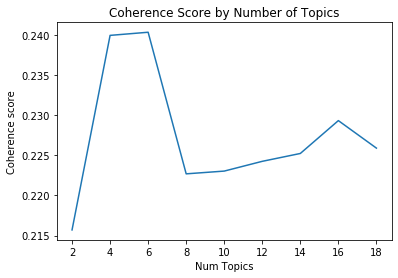

In [163]:

    #reads in messy files and cleans as much as possible
#     remove_extraneous_text('/Users/arielledror/Text_Mining/original_data/', 
#                            '/Users/arielledror/Text_Mining/clean_data/')
    
    #converts clean-ish files to 
    state_corpus = prepare_for_modeling('/Users/arielledror/Text_Mining/clean_data/')

    #runs the coherence model
    lda_model_1 = create_potential_models(state_corpus)
    
    #plots the coherence model 
    x = lda_model_1[1]
    y = lda_model_1[2]
    plt.plot(x, y)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.title("Coherence Score by Number of Topics")
    plt.show()

The max coherence score here is somewhere around six topics, so that is the number of topics that we use for the remaining analysis. However, a coherence score this low is **bad**. At this point, I ordinarily would have gone back to the drawing board. However, since it is merely an exploratory exercise, I continued anyways. 

#### Optimal LDA in Gensim

In [142]:
lda_model_best = generate_best_model(state_corpus)

#top 20 words for best 6 topics
pprint.pprint(lda_model_1[0].print_topics(6, 20))

[(13,
  '0.015*"person" + 0.010*"public" + 0.009*"court" + 0.009*"except" + '
  '0.009*"office" + 0.008*"power" + 0.008*"officer" + 0.008*"house" + '
  '0.007*"territory" + 0.007*"member" + 0.007*"district" + 0.007*"land" + '
  '0.007*"election" + 0.007*"vote" + 0.006*"general" + 0.006*"elected" + '
  '0.006*"right" + 0.006*"year" + 0.006*"property" + 0.005*"state"'),
 (7,
  '0.011*"public" + 0.011*"court" + 0.010*"election" + 0.010*"office" + '
  '0.010*"person" + 0.010*"member" + 0.009*"district" + 0.008*"officer" + '
  '0.008*"except" + 0.007*"case" + 0.007*"property" + 0.007*"elected" + '
  '0.007*"united" + 0.006*"land" + 0.006*"prescribed" + 0.006*"supreme" + '
  '0.006*"general" + 0.006*"governor" + 0.006*"right" + 0.006*"vote"'),
 (4,
  '0.014*"person" + 0.010*"election" + 0.010*"officer" + 0.010*"office" + '
  '0.009*"member" + 0.009*"court" + 0.009*"public" + 0.008*"district" + '
  '0.008*"territory" + 0.007*"except" + 0.007*"land" + 0.006*"general" + '
  '0.006*"power" + 0.0

As we can see, most of these words are duplicates of each other, so I didn't really think I could realistically come up with distinct ideas for each category. Is this a side effect of the corpus itself of the algorithm? A little bit of online research actually said that the implementation of LDA in gensim is typically not great. Gensim actually has a wrapper function for MALLET, which we used in class. However, the implementation is incredibly buggy and I could never get it to work. Instead, I ended up using MALLET in its terminal interface, exporting the results to new files and then importing them here for graphing and analysis. 

For the MALLET analysis, I used the six topics that the gensim algorithm said was optimal. Here are the lists of words that MALLET came up with:

![](/Users/arielledror/Text_Mining/mallet_topics.png)

I assigned these roughly the following categories: 
1. **Geographic Boundaries:** Setting the borders of a state
2. **Voting:** Voting Procedure, Rules, Days, etc. 
3. **Taxes and Money:** Procedures for collection of taxes and what they might be used for
4. **Judiciary Voting:** Voting for judges (in places where this is a thing)
5. **Legislative Voting:** Voting for legislative officials

Like the gensim implementation, MALLET definitely struggled to detect many distinct categories, but I continued on my analysis anyways. 

In [ ]:
#### Analysis of MALLET Results 

year_written
0       1
1662    1
1776    6
1777    1
1792    1
1802    1
1812    1
1816    1
1817    1
1818    1
1819    1
1835    1
1838    1
1843    1
1846    1
1857    1
1859    1
1861    1
1864    2
1866    1
1876    1
1889    4
1890    1
1895    1
1896    1
1907    1
1911    1
1959    1
Name: state, dtype: int64
    year_written  geographic_boundaries    voting  taxes_and_money  \
0              0               0.013747  0.059132         0.010818   
1           1662               0.483236  0.265385         0.001290   
2           1776               0.004120  0.509843         0.002489   
3           1777               0.000021  0.405818         0.000016   
4           1792               0.000024  0.076553         0.000019   
5           1802               0.002593  0.057012         0.000020   
6           1812               0.000029  0.089489         0.000023   
7           1816               0.000019  0.040929         0.000015   
8           1817               0.000020  0.043644  

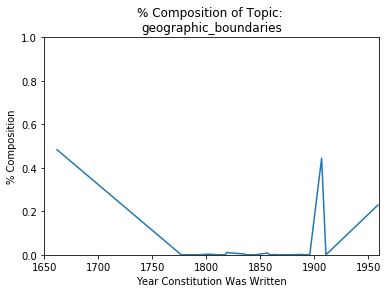

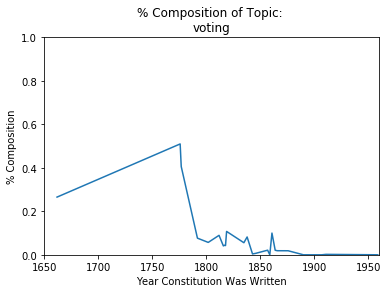

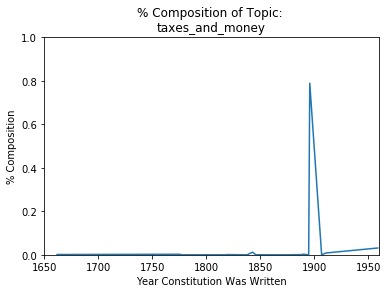

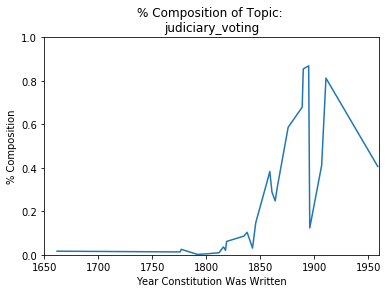

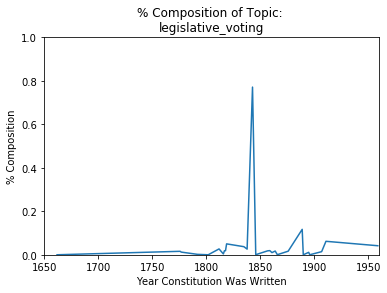

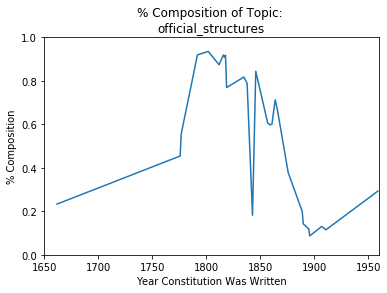

In [166]:
mallet_results = pd.read_csv('/Users/arielledror/Text_Mining/clean_data_composition.csv', 
                            na_values = 'NA')

mallet_results['year_written'] = mallet_results['year_written'].astype(int)

year_written_counts = mallet_results.groupby('year_written').nunique()

#getting mean scores by category by year (since some years have multiple constitutions
mallet_by_year = mallet_results.groupby('year_written', as_index = False).agg({'geographic_boundaries': 'mean', 
                                                            'voting' : 'mean',
                                                            'taxes_and_money' : 'mean',
                                                            'judiciary_voting' : 'mean',
                                                            'legislative_voting': 'mean',
                                                            'official_structures' : 'mean'})
mallet_filter = mallet_by_year.query('year_written > 0')

categories = ['geographic_boundaries', 'voting', 'taxes_and_money', 'judiciary_voting', 'legislative_voting', 'official_structures']
for i in categories:
    
    x = mallet_filter['year_written']
    y = mallet_filter[i]

    plt.plot(x, y)
    plt.xlim(1650, 1960)
    plt.ylim(0.0, 1.0)
    plt.xlabel('Year Constitution Was Written')
    plt.ylabel('% Composition')
    plt.title('% Composition of Topic: \n' + i)
    plt.show()


First, I graphed the mean % composition of each topic by year to see if there are any changes over time. Overall, there isn't any particularly discernable trends. Values tend to jump around, which leads me to believe that any trend (if there is one) is probably not temporal. Interesting, the judiciary category does seem to increase in composition over time. I wonder if the value of a strong judiciary emerged as an important concept emerged as laws developed and judicial precendents grew. 

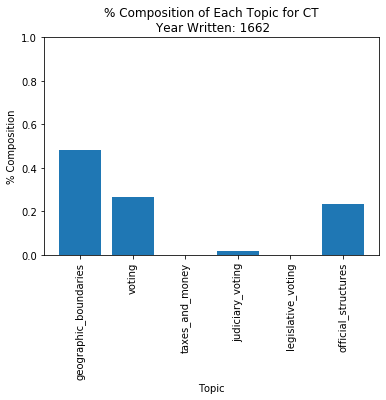

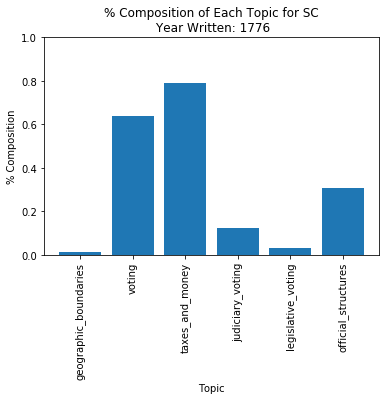

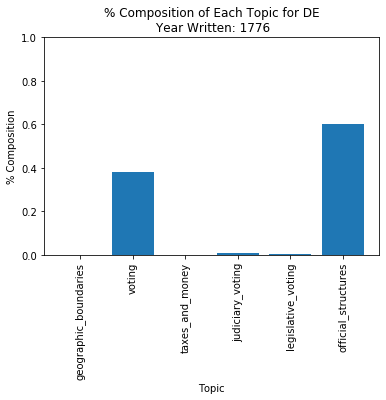

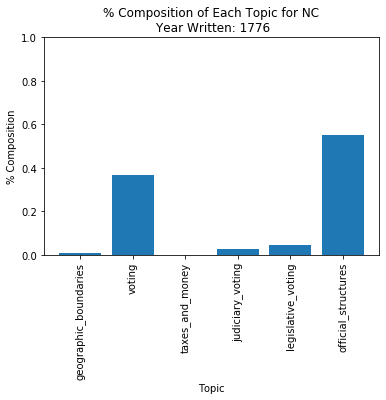

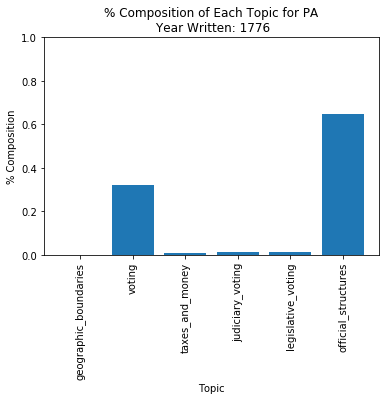

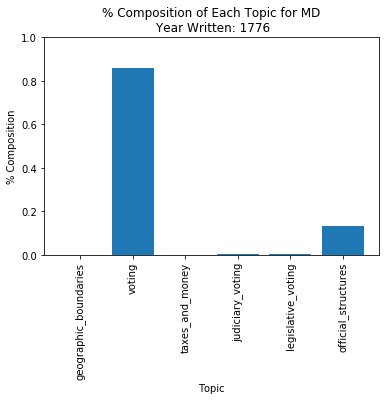

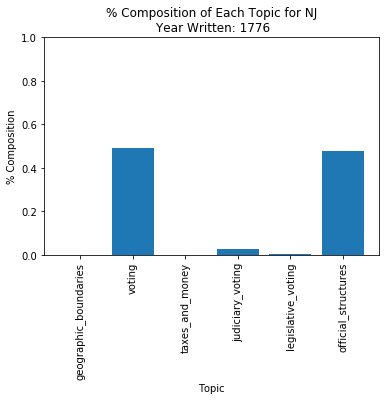

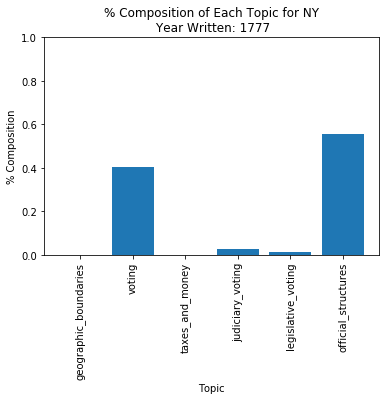

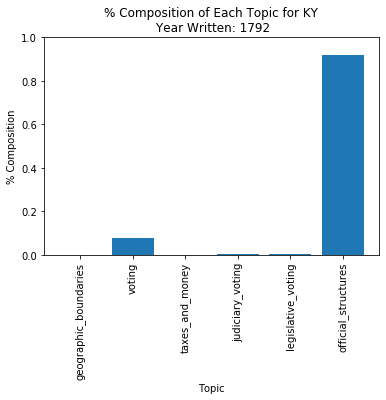

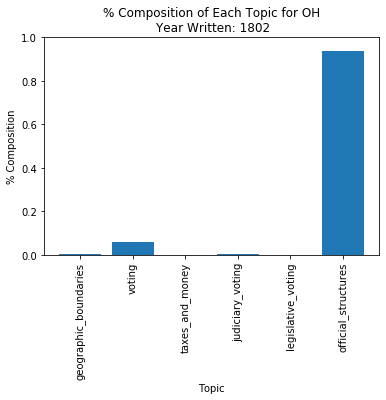

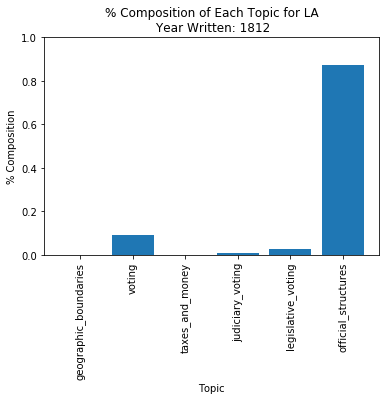

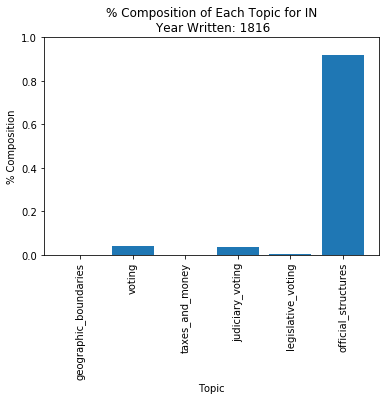

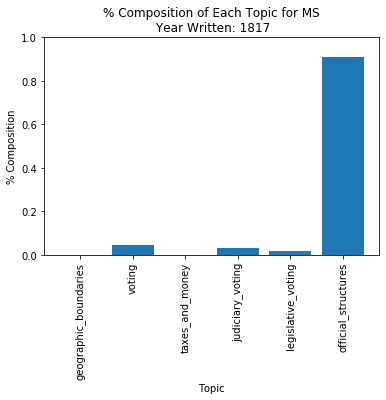

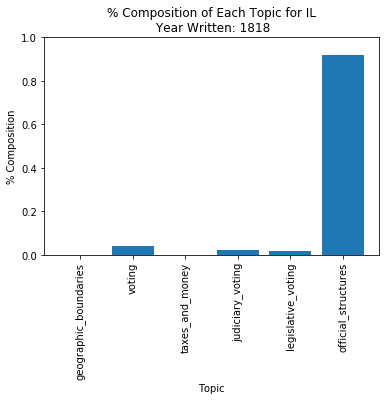

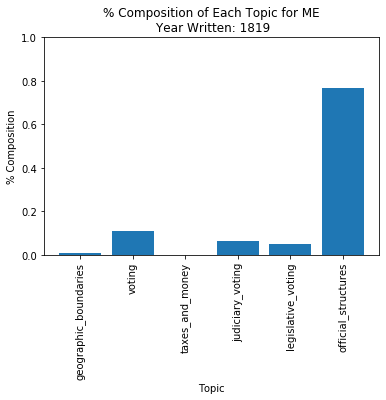

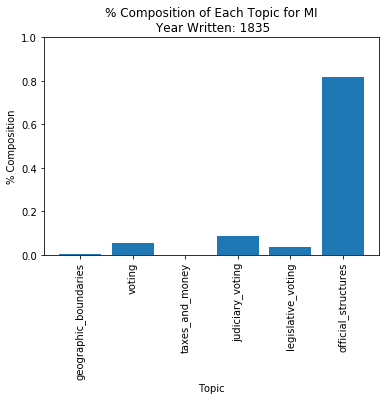

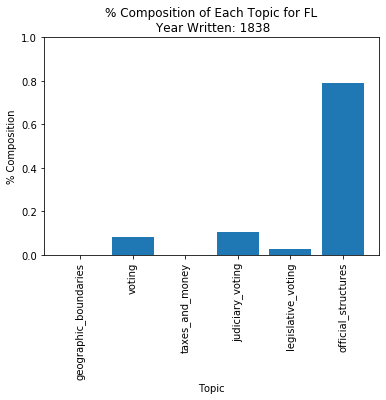

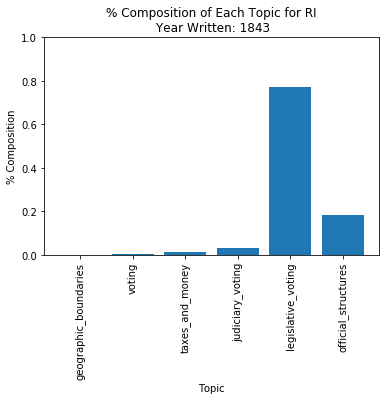

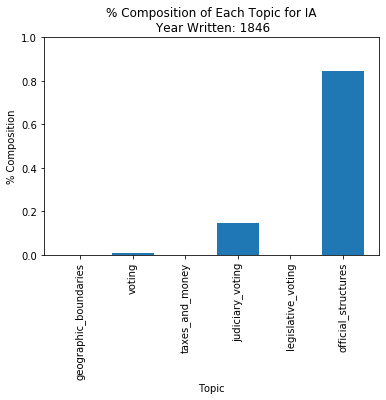

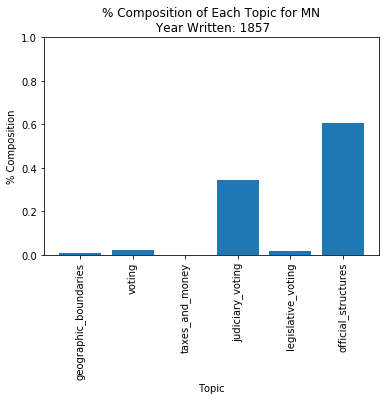

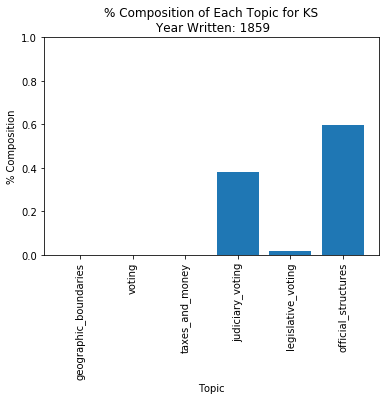

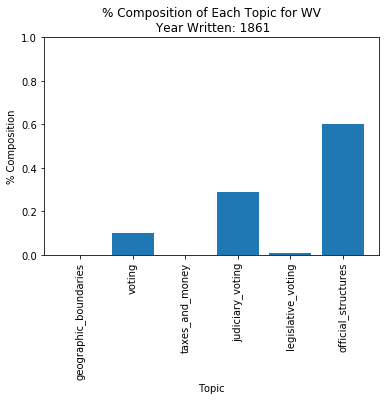

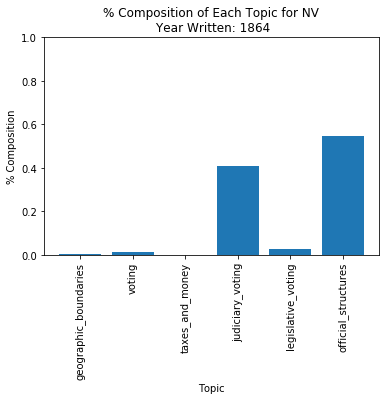

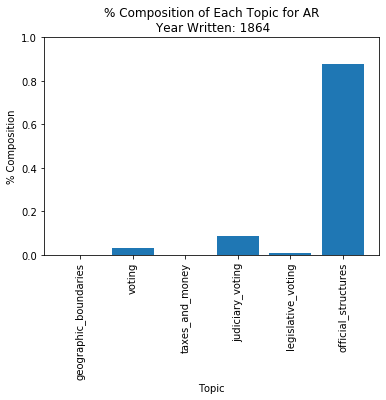

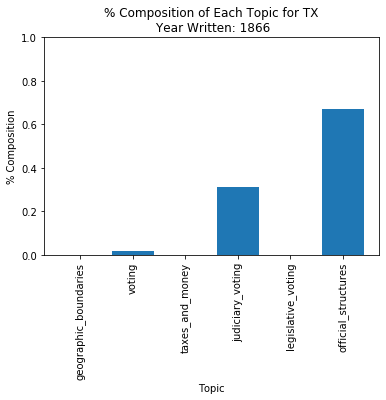

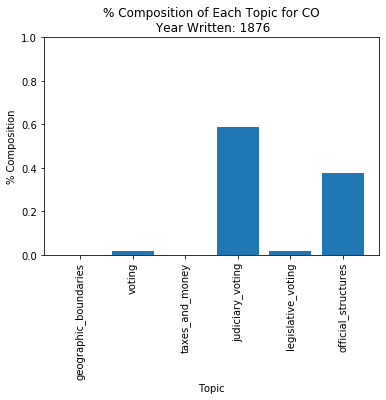

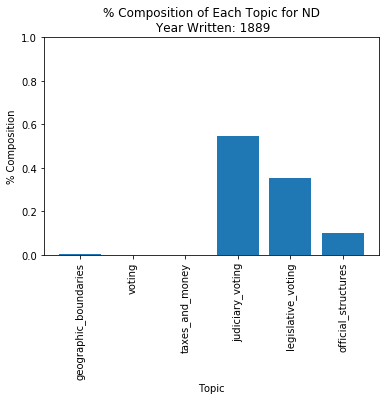

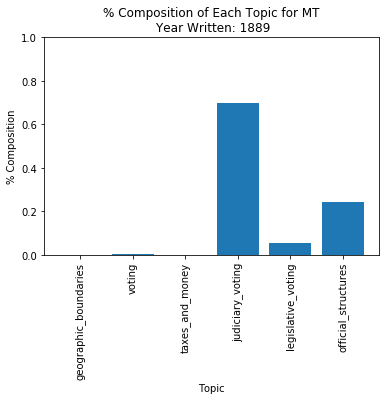

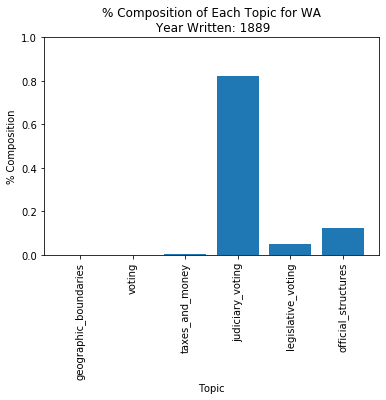

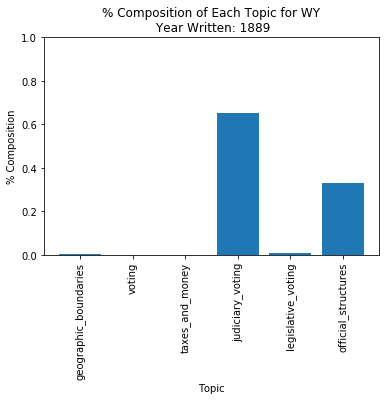

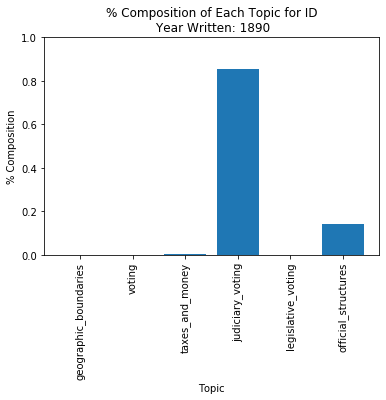

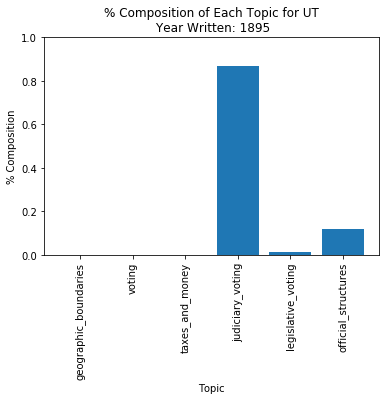

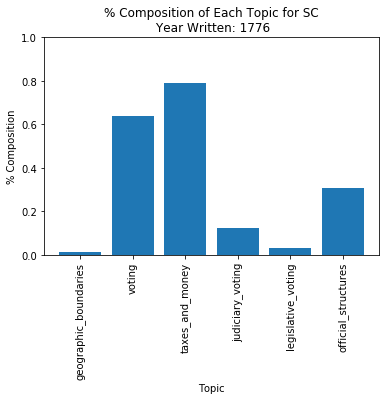

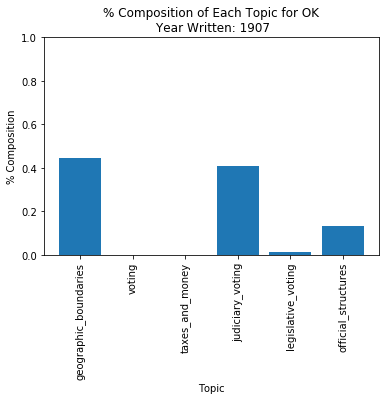

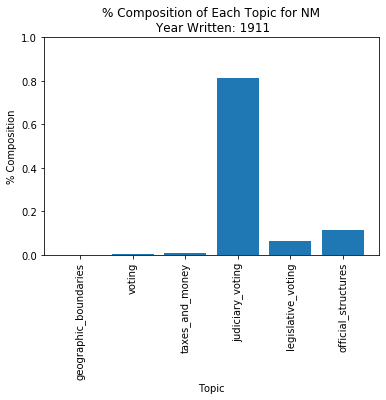

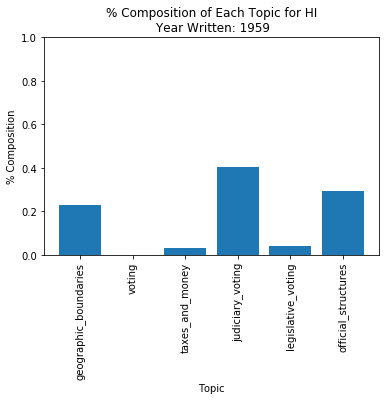

In [167]:
#graphing topics by state
mallet_by_state = mallet_results.query('year_written > 0')

mallet_ascend = mallet_by_state.sort_values('year_written', ascending = True)

#format for graphing
mallet_pivot = pd.melt(mallet_ascend, id_vars = ['state', 'year_written'], value_vars = ['geographic_boundaries', 'voting',
                                                                          'taxes_and_money', 'judiciary_voting', 'legislative_voting',
                                                                          'official_structures'])
states = mallet_ascend['state']

for i in states:
    one_state = mallet_pivot[mallet_pivot['state'].str.contains(i)] 
    year_written = one_state['year_written'].iloc[0]
    x = one_state['variable']
    y = one_state['value']
    plt.ylim(0.00, 1.00)
    plt.xticks(rotation=90)
    plt.xlabel('Topic')
    plt.ylabel('% Composition')
    plt.title('% Composition of Each Topic for ' + i + '\n Year Written: ' + str(year_written))
    plot = plt.bar(x, y)
    plt.show()
    


Next, I wanted to just look to see which states were more composed of one topic than another. I generated barcharts for each state and arranged them according to the date in which the constitution was written. If I had more time, I would have arranged this spatially somehow because I wonder if geographic distribution has anything to do with the saliency of one topic over another and it's easier to analyze rather than scrolling. I would expect the 13 colonies that were available for this analysis to have generally similar distributions since they had generally similar feelings towards Britain and are geographically close. Even there, I do not see any particular trends. Potentially interesting is that states that were generally incorporated soon after the Revolutionary War and as a result of the Louisiana Purchase (Kentucky, Ohio, Louisiana, Indiana, Mississippi, Illinois, Michigan) tend to have high compositions of the **official structures** topic. Interestingly, the dip in 1843 seen in the ***% Composition Line Graph for Official Structures*** above is Rhode Island. In 1843, Rhode Island adopted its first constitution even though it had been a state for many years. Perhaps the reason for a low composition of **official structure** is because the government was already functioning. 

Overall, I think it is fair to see that I did not glean much historical insight from this exercise because my topics were not particularly distinct. I think there are a couple ways that I could have improved that. First, I would have liked to included bigrams and trigrams, which considers words that frequently appear together as one word. I think there are probably a lot of instances where that is the case (especially because a lot of legal documents use similar words). However, the bigram and trigram functions in gensim were not working and I don't think that MALLET has this option. I would also have also played around a bit with the stop words. I wonder if I either added too many or not enough. 

I think if I would have implemented this in R, then I would have been able to take it a bit further. However, a lot of my time was spent reaquainting myself with Python for the added challenge! Although I don't have a lot of historical takeaway, I definitely had a lot of technical takeaways that I hope to implement with other corpuses.